#Data preparation

In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.7.0
Found GPU at: /device:GPU:0

Sat Jan 22 22:24:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    31W /  70W |    264MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

In [2]:
from tensorflow.keras.datasets import cifar10
(train_X, train_y), (test_X, test_y) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
#We need to make onehot vectors out of the labels
from tensorflow.keras.utils import to_categorical
train_y = to_categorical(train_y,num_classes=10)
test_y = to_categorical(test_y,num_classes=10)

In [4]:
#@title Data augmentation
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 512

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.4,
                                   brightness_range=(.5, 1.5),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow(
                    train_X, train_y,
                    batch_size=batch_size,
                    shuffle=True)

num_classes = 10

# Flow test images in batches using val_datagen generator
test_generator = test_datagen.flow(
                    test_X, test_y,
                    batch_size=batch_size,
                    shuffle=True)

train_steps = len(train_generator)
test_steps = len(test_generator)

#ResNet18 model

In [5]:
#code for resnet18 (18-layer ResNet)
DEFAULT_FILTER_SIZE = 3
INIT_LR = 1e-3

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
def identity_block(input, f, filters, conv_num, step):
    
    # Names of layers
    conv_name_base = 'res_' + str(conv_num) + '_' + str(step)
    
    F1, F2 = filters
    
    # Save skip value
    x_skip = input
    
    # First component of main path
    x = layers.Conv2D(filters = F1, kernel_size = (f, f),
                      padding='same',
                      name = conv_name_base + '_a')(input)

    x = layers.Activation('relu')(x)
    
    # Third component of main path 
    x = layers.Conv2D(filters = F2, kernel_size = (f, f),
                      padding='same',
                      name = conv_name_base + '_b')(x)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    x = layers.Add()([x, x_skip])
    x = layers.Activation('relu')(x)
    
    return x


In [7]:
def conv_block(input, f, filters, conv_num, step, s=2):
    
    # Names of layers
    conv_name_base = 'res_' + str(conv_num) + '_' + str(step)
    
    F1, F2 = filters
    
    # Save skip value
    x_skip = input
    
    # First layer of main path
    x = layers.Conv2D(filters=F1, kernel_size=(f, f), strides=(s,s),
                      padding='same',
                      name=conv_name_base + '_a')(input)

    x = layers.Activation('relu')(x)

    # Second layer of main path 
    x = layers.Conv2D(filters = F2, kernel_size = (f, f),
                      strides=(1,1),
                      padding='same',
                      name = conv_name_base + '_b')(x)


    # SKIP CONNECTION #
    x_skip = layers.Conv2D(filters=F2, kernel_size=(1, 1), strides=(s, s),
                    name=conv_name_base + '_1')(x_skip)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    x = layers.Add()([x, x_skip])
    x = layers.Activation('relu')(x)
    
    return x

In [8]:
def ResNet18(input_shape, classes):
  # Define the input as a tensor with shape input_shape
    x_input = layers.Input(input_shape)
    
    # Zero-Padding
    x = layers.ZeroPadding2D((3, 3))(x_input)
    
    # Conv 1
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Conv 2
    x = conv_block(x, f=DEFAULT_FILTER_SIZE, filters=[64,64], conv_num=2, step=1, s=1)
    x = identity_block(x, f=DEFAULT_FILTER_SIZE, filters=[64,64], conv_num=2, step=2)

    # Conv 3
    x = conv_block(x, f=DEFAULT_FILTER_SIZE, filters=[128,128], conv_num=3, step=1, s=2)
    x = identity_block(x, f=DEFAULT_FILTER_SIZE, filters=[128,128], conv_num=3, step=2)

    # Conv 4
    x = conv_block(x, f=DEFAULT_FILTER_SIZE, filters=[256,256], conv_num=4, step=1)
    x = identity_block(x, f=DEFAULT_FILTER_SIZE, filters=[256,256], conv_num=4, step=2)

    # Conv 5
    x = conv_block(x, f=DEFAULT_FILTER_SIZE, filters=[512,512], conv_num=5, step=1)
    x = identity_block(x, f=DEFAULT_FILTER_SIZE, filters=[512,512], conv_num=5, step=2)

    #Pooling layer
    x = layers.AveragePooling2D(pool_size=(2,2), padding='same')(x)

    # Output layer
    x = layers.Flatten()(x)
    output = layers.Dense(classes, activation='softmax', name='fc' + str(classes))(x)

    model = Model(x_input, output, name="ResNet_18")

    model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=INIT_LR),
                metrics=['accuracy'])


    return model

#AGC implementation

In [9]:
import tensorflow as tf

def compute_norm(x, axis, keepdims):
    return tf.math.reduce_sum(x ** 2, axis=axis, keepdims=keepdims) ** 0.5

def unitwise_norm(x):
    if len(x.get_shape()) <= 1:  # Scalars and vectors
        axis = None
        keepdims = False
    elif len(x.get_shape()) in [2, 3]:  # Linear layers of shape IO or multihead linear
        axis = 0
        keepdims = True
    elif len(x.get_shape()) == 4:  # Conv kernels of shape HWIO
        axis = [0, 1, 2,]
        keepdims = True
    else:
        raise ValueError(f"Got a parameter with shape not in [1, 2, 4]! {x}")
    return compute_norm(x, axis, keepdims)


def adaptive_clip_grad(parameters, gradients, clip_factor=0.01,
                       eps=1e-3):
    new_grads = []
    for (params, grads) in zip(parameters, gradients):
        p_norm = unitwise_norm(params)
        max_norm = tf.math.maximum(p_norm, eps) * clip_factor
        grad_norm = unitwise_norm(grads)
        clipped_grad = grads * (max_norm / tf.math.maximum(grad_norm, 1e-6))
        new_grad = tf.where(grad_norm < max_norm, grads, clipped_grad)
        new_grads.append(new_grad)
    return new_grads

In [10]:
import tensorflow as tf

class ResNet18_AGC_Model(Model):

  def __init__(self, inputshape, name, threshold=1e-3):
        super(ResNet18_AGC_Model, self).__init__()
        self.threshold = threshold
        self.resnet = ResNet18(input_shape=inputshape, classes=10)

  #this bit of code is from keras API
  def train_step(self, data):
    # Unpack the data
    images, y = data

    with tf.GradientTape() as tape:
        y_pred = self.resnet(images)  # Forward pass
        # Compute the loss value
        loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    # Compute gradients
    trainable_vars = self.resnet.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update gradients
    updated_grad = adaptive_clip_grad(trainable_vars, gradients, self.threshold)
    # Update weights
    self.optimizer.apply_gradients(zip(updated_grad, trainable_vars))
    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    images, labels = data
    predictions = self.resnet(images, training=False)
    loss = self.compiled_loss(labels, predictions)
    self.compiled_metrics.update_state(labels, predictions)
    return {m.name: m.result() for m in self.metrics}

  def call(self, inputs):
    return self.resnet(inputs)

#Model creation and training

In [11]:
from tensorflow.keras.optimizers import Adam
clipping_factor = 0.08 # As described in the base paper of this study
resnet18 = ResNet18_AGC_Model((32,32,3), threshold=0.08, name='resnet18_agc')

resnet18.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=1e-3),
            metrics=['accuracy'])

In [12]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show() 

Epoch 1/100
98/98 [==============================] - 44s 388ms/step - loss: 2.0780 - accuracy: 0.2168 - val_loss: 1.8751 - val_accuracy: 0.3242
Epoch 2/100
98/98 [==============================] - 34s 349ms/step - loss: 1.8432 - accuracy: 0.3239 - val_loss: 1.6944 - val_accuracy: 0.3889
Epoch 3/100
98/98 [==============================] - 35s 353ms/step - loss: 1.7356 - accuracy: 0.3712 - val_loss: 1.5670 - val_accuracy: 0.4320
Epoch 4/100
98/98 [==============================] - 34s 352ms/step - loss: 1.6640 - accuracy: 0.3998 - val_loss: 1.5091 - val_accuracy: 0.4611
Epoch 5/100
98/98 [==============================] - 35s 354ms/step - loss: 1.6148 - accuracy: 0.4205 - val_loss: 1.4208 - val_accuracy: 0.4830
Epoch 6/100
98/98 [==============================] - 35s 353ms/step - loss: 1.5743 - accuracy: 0.4369 - val_loss: 1.3949 - val_accuracy: 0.4972
Epoch 7/100
98/98 [==============================] - 35s 352ms/step - loss: 1.5199 - accuracy: 0.4572 - val_loss: 1.3719 - val_accuracy:

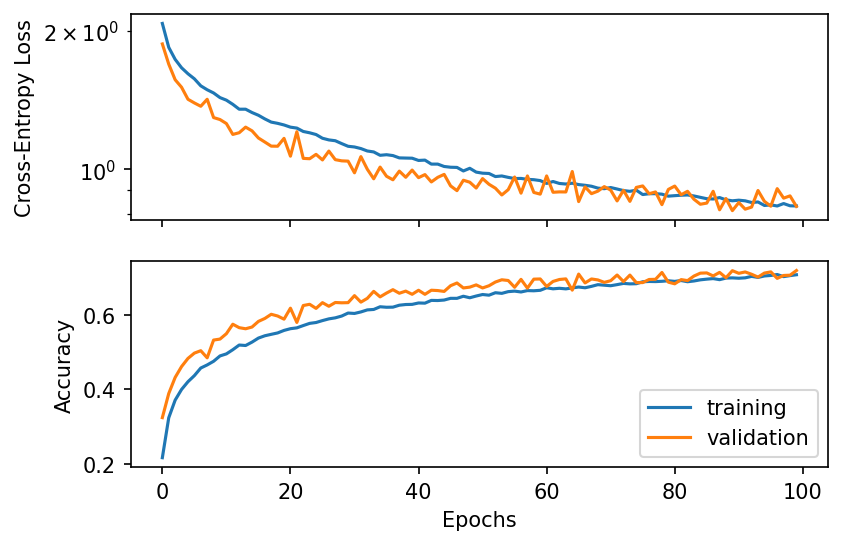

In [13]:
history = resnet18.fit(train_generator,
                        steps_per_epoch=train_steps,# trained with 512
                        epochs=100,
                        validation_data=test_generator,
                        validation_steps=test_steps
                       )
plot_history(history)